In [1]:
import pandas as pd

DATA_DIR = "/home/mnowak/Downloads/piec"
MODEL_OUT = "/home/mnowak/PycharmProjects/CudoFlash/out"

path = f"{DATA_DIR}/data_2021-04-19.csv"

data = pd.read_csv(path).drop(columns=['Unnamed: 0'])
data['Czas'] = pd.to_datetime(data['Czas']).dt.round("1min")
# data["sec"] = data['Czas'].astype(np.int64) // 10**9


data = data.drop(columns=["Nadawa_pylow", 'Strata_pasa', 'S600', 'S500', 'S00',
       'S100', 'Nadawa_koncentratu', 'Nadawa_1', 'Nadawa_2', 'Tlen_lanca',
       'Tlen_procesowe', 'Powietrze_procesowe', 'Przetlenienie',
       'Zawartosc_wegla', 'Zawartosc_siarki', 'Udzial_nadziarna',
       'Udzial_podziarna', 'Poziom_topu', 'Kat_dystrybucji',
       'Straty_odstojnika', 'Temperatura_zuzla', 'Drgania_kotla'])



data = data.rename(columns={"Powietrze_dystrybucyjne": "pow_dyst",
             "Zawartosc_tlenu": "zaw_tle",
             "Predkosc_dmuchu": "pre_dmu",
             "Strata_laczna": "str_lac"
             })

data = data.groupby("Czas").agg({
    "pow_dyst": "mean",
    "zaw_tle": "mean",
    "pre_dmu": "mean",
    "str_lac": "mean"
})

data.reset_index(drop=True, inplace=True)

data

,pow_dyst,zaw_tle,pre_dmu,str_lac
0,2700.000000,81.0,50.0,23.363603
1,2700.000000,81.0,50.0,23.458761
2,2700.000000,81.0,50.0,23.540884
3,2700.000000,81.0,50.0,23.566272
4,2700.000000,81.0,50.0,23.558922
...,...,...,...,...
15818,2700.000000,81.0,45.0,23.811989
15819,3140.677966,81.0,45.0,23.688618
15820,3165.573770,81.0,45.0,23.605392
15821,2700.000000,81.0,45.0,23.528355


In [2]:
# Agregacja i normalizacja

POW_DYST_NORM = {"min": 1900.,"max": 3500.}
ZAW_TLE_NORM = {"min": 65., "max": 81.}
PRE_DMU = { "min": 40.,"max": 70.}
STR_LAC = { "min": 15.,"max": 30.}

df = data.copy()
df["pow_dyst"] = (df["pow_dyst"] - POW_DYST_NORM["min"]) / (POW_DYST_NORM["max"] - POW_DYST_NORM["min"])
df["zaw_tle"] = (df["zaw_tle"] - ZAW_TLE_NORM["min"]) / (ZAW_TLE_NORM["max"] - ZAW_TLE_NORM["min"])
df["pre_dmu"] = (df["pre_dmu"] - PRE_DMU["min"]) / (PRE_DMU["max"] - PRE_DMU["min"])
df["str_lac"] = (df["str_lac"] - STR_LAC["min"]) / (STR_LAC["max"] - STR_LAC["min"])


df

,pow_dyst,zaw_tle,pre_dmu,str_lac
0,0.500000,1.0,0.333333,0.557574
1,0.500000,1.0,0.333333,0.563917
2,0.500000,1.0,0.333333,0.569392
3,0.500000,1.0,0.333333,0.571085
4,0.500000,1.0,0.333333,0.570595
...,...,...,...,...
15818,0.500000,1.0,0.166667,0.587466
15819,0.775424,1.0,0.166667,0.579241
15820,0.790984,1.0,0.166667,0.573693
15821,0.500000,1.0,0.166667,0.568557


In [3]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, nms = {}):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(f'{nms[j]}(t-%d)' % i) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [f'{nms[j]}(t)' for j in range(n_vars)]
		else:
			names += [f'{nms[j]}(t+%d)' % i for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [4]:
l_names = {
    0: "pow_dyst",
    1: "zaw_tle",
    2: "pre_dmu",
}
r_names = {
    0: "str_lac"
}

aa = series_to_supervised(df[["pow_dyst", "zaw_tle", "pre_dmu"]], 16, 1, False, l_names)
bb = series_to_supervised(df[["str_lac"]], 16, 16, False, r_names)

data_new = pd.concat([aa, bb], axis=1)
data_new = data_new.iloc[16:len(data_new)-600]
data_new

,pow_dyst(t-16),zaw_tle(t-16),pre_dmu(t-16),pow_dyst(t-15),zaw_tle(t-15),pre_dmu(t-15),pow_dyst(t-14),zaw_tle(t-14),pre_dmu(t-14),pow_dyst(t-13),...,str_lac(t+6),str_lac(t+7),str_lac(t+8),str_lac(t+9),str_lac(t+10),str_lac(t+11),str_lac(t+12),str_lac(t+13),str_lac(t+14),str_lac(t+15)
16,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,...,0.492159,0.503726,0.515607,0.524764,0.529138,0.529299,0.525824,0.519643,0.513570,0.505238
17,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,...,0.503726,0.515607,0.524764,0.529138,0.529299,0.525824,0.519643,0.513570,0.505238,0.497408
18,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,...,0.515607,0.524764,0.529138,0.529299,0.525824,0.519643,0.513570,0.505238,0.497408,0.490897
19,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,...,0.524764,0.529138,0.529299,0.525824,0.519643,0.513570,0.505238,0.497408,0.490897,0.478438
20,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,1.0,0.333333,0.5000,...,0.529138,0.529299,0.525824,0.519643,0.513570,0.505238,0.497408,0.490897,0.478438,0.470317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15218,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,...,-0.309336,-0.310556,-0.309707,-0.310021,-0.310337,-0.311404,-0.310555,-0.311124,-0.311059,-0.311066
15219,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,...,-0.310556,-0.309707,-0.310021,-0.310337,-0.311404,-0.310555,-0.311124,-0.311059,-0.311066,-0.310559
15220,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,...,-0.309707,-0.310021,-0.310337,-0.311404,-0.310555,-0.311124,-0.311059,-0.311066,-0.310559,-0.311693
15221,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,0.0,0.333333,-0.5625,...,-0.310021,-0.310337,-0.311404,-0.310555,-0.311124,-0.311059,-0.311066,-0.310559,-0.311693,-0.312369


In [5]:
values = data_new.values
train = values[:1000, :]
test = values[1000:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1000, 1, 82) (1000,) (14207, 1, 82) (14207,)


Epoch 1/50
14/14 - 18s - loss: 0.2649 - val_loss: 0.0897
Epoch 2/50
14/14 - 0s - loss: 0.1161 - val_loss: 0.1214
Epoch 3/50
14/14 - 0s - loss: 0.0803 - val_loss: 0.1088
Epoch 4/50
14/14 - 0s - loss: 0.0615 - val_loss: 0.0723
Epoch 5/50
14/14 - 0s - loss: 0.0714 - val_loss: 0.0834
Epoch 6/50
14/14 - 0s - loss: 0.0551 - val_loss: 0.0640
Epoch 7/50
14/14 - 0s - loss: 0.0522 - val_loss: 0.0594
Epoch 8/50
14/14 - 0s - loss: 0.0476 - val_loss: 0.0586
Epoch 9/50
14/14 - 0s - loss: 0.0424 - val_loss: 0.0609
Epoch 10/50
14/14 - 0s - loss: 0.0418 - val_loss: 0.0652
Epoch 11/50
14/14 - 0s - loss: 0.0455 - val_loss: 0.0680
Epoch 12/50
14/14 - 0s - loss: 0.0460 - val_loss: 0.0656
Epoch 13/50
14/14 - 0s - loss: 0.0426 - val_loss: 0.0649
Epoch 14/50
14/14 - 0s - loss: 0.0431 - val_loss: 0.0675
Epoch 15/50
14/14 - 0s - loss: 0.0457 - val_loss: 0.0677
Epoch 16/50
14/14 - 0s - loss: 0.0441 - val_loss: 0.0690
Epoch 17/50
14/14 - 0s - loss: 0.0461 - val_loss: 0.0726
Epoch 18/50
14/14 - 0s - loss: 0.0513 -

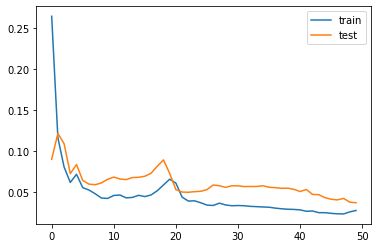

In [6]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as pyplot

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
from math import sqrt
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat * (STR_LAC["max"] - STR_LAC["min"]) + STR_LAC["min"]
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y * (STR_LAC["max"] - STR_LAC["min"]) + STR_LAC["min"]
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.745


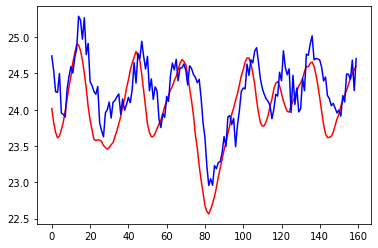

In [12]:
pyplot.plot(inv_y[40:200], "r")
pyplot.plot(inv_yhat[40:200], "b")
pyplot.show()

In [18]:
model.save(MODEL_OUT)



INFO:tensorflow:Assets written to: /home/mnowak/PycharmProjects/CudoFlash/out/assets


INFO:tensorflow:Assets written to: /home/mnowak/PycharmProjects/CudoFlash/out/assets
